### Pivot Tables
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data. The difference between pivot tables and GroupBy can sometimes cause confusion; it helps me to think of pivot tables as essentially a multidimensional version of GroupBy aggregation. That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
## Using a groupby to look at survival rate by gender
titanic.groupby('sex')['survived'].mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

* This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class. 
* Using the vocabulary of GroupBy, we might proceed using something like this: we group by class and gender, select survival, apply a mean aggregate, combine the resulting groups, and then unstack the hierarchical index to reveal the hidden multidimensionality.

In [6]:
titanic.groupby(['sex', 'class'])['survived'].agg('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [7]:
# Wide Format
titanic.groupby(['sex', 'class'])['survived'].agg('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


* As this two-dimensional `GroupBy` is common enough that Pandas includes a convenience routine, `pivot_table`
    * This can succinctly handles this type of multidimensional aggregation

### Pivot Table Syntax

In [8]:
titanic.pivot_table(values='survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


#### Dframe Pivot Table Quick Syntax/Argument Check
* values : column to aggregate (target column we want an aggregated method called on)
* index : Keys to group by on the pivot table `index`
* columns : Key to group by on the pivot table `column`
* aggfunc : functions, list of functions, dict common (can call an agg func on a value column being aggregated

* Just as in `GroupBy`, the grouping in pivot tables can be specified with multiple levels
    * For example, we might be interested in looking at age as a third dimension
    * pd.cut is a quick way to bin ages (think histogram)

In [9]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table(values='survived', index=['sex', age], columns='class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [12]:
len(age), len(titanic), type(age)

(891, 891, pandas.core.series.Series)

* Not uncommon to add this series to the dataframe as a secondary column for the binned ages then pass to the index argument as a key and not a series
    * As seen in the previous noteboook (Aggregation & Grouping) we can pass the series/array or values to groupby and they'll associate just fine

* We can apply this same strategy when working with columns as well

In [13]:
# use a similar quantile type separation with pd.qcut
fare = pd.qcut(titanic['fare'], 2)
fare[:5]

0     (-0.001, 14.454]
1    (14.454, 512.329]
2     (-0.001, 14.454]
3    (14.454, 512.329]
4     (-0.001, 14.454]
Name: fare, dtype: category
Categories (2, interval[float64, right]): [(-0.001, 14.454] < (14.454, 512.329]]

In [14]:
titanic.pivot_table(values='survived', index=['sex', age], columns=['class', fare])

class                      First                             Second  \
fare            (-0.001, 14.454] (14.454, 512.329] (-0.001, 14.454]   
sex    age                                                            
female (0, 18]               NaN          0.909091         1.000000   
       (18, 80]              NaN          0.972973         0.880000   
male   (0, 18]               NaN          0.800000         0.000000   
       (18, 80]              0.0          0.391304         0.098039   

class                                        Third                    
fare            (14.454, 512.329] (-0.001, 14.454] (14.454, 512.329]  
sex    age                                                            
female (0, 18]           1.000000         0.714286          0.318182  
       (18, 80]          0.914286         0.444444          0.391304  
male   (0, 18]           0.818182         0.260870          0.178571  
       (18, 80]          0.030303         0.125000          0.192308

In [16]:
### Applying multiple aggregate methods on our sub-groups created with the pivot table
## Note here being the values or columns you want the aggfuncs run on can be declared just in the aggfunc dictionary
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':'sum', 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [17]:
# Compute totals along each grouping (Using **margins**)
titanic.pivot_table(values='survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


* Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.

### Example: Birthrate Data

In [18]:
!curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  258k  100  258k    0     0   937k      0 --:--:-- --:--:-- --:--:--  939k


In [19]:
births = pd.read_csv('births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


* Taking a look at the data, we see that it’s relatively simple — it contains the number of births grouped by date and gender:

In [20]:
# Use a decade column to take a look at male and female births as a function of decades
births['decade'] = 10 * (births['year']//10)
births.pivot_table(values='births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


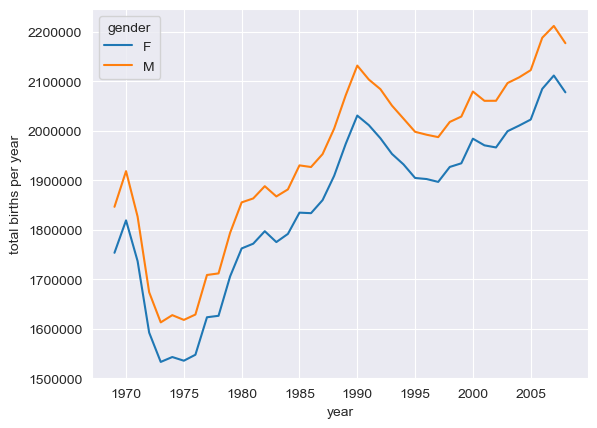

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
births.pivot_table(values='births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

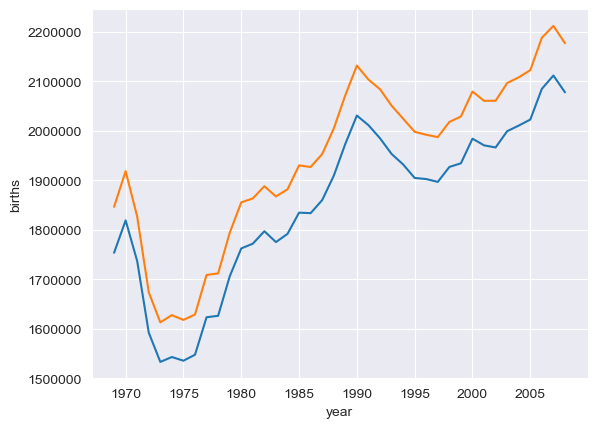

In [32]:
piv = births.pivot_table(values='births', index='year', columns='gender', aggfunc='sum')
sns.lineplot(x=piv.index, y='F', data=piv)
sns.lineplot(x=piv.index, y='M', data=piv)
plt.ylabel('births')
plt.ticklabel_format(style='plain', axis='y')
# sns.lineplot(x='year', y=,
#             data=births)

### Vectorized String Operations

* Pandas includes features to address both this need for vectorized string operations and for correctly handling missing data via the str attribute of Pandas Series and Index objects containing strings.

In [35]:
names = pd.Series(['peter', 'Paul', None, 'MARY', 'gUIDO'])
names

0    peter
1     Paul
2     None
3     MARY
4    gUIDO
dtype: object

In [36]:
[x.capitalize() for x in ['peter', 'Paul', None, 'MARY', 'gUIDO']]

AttributeError: 'NoneType' object has no attribute 'capitalize'

In [37]:
# Pandas can handle!
names.str.capitalize()

0    Peter
1     Paul
2     None
3     Mary
4    Guido
dtype: object

In [38]:
monte = pd.Series(['Graham Chapman', 'John Cleese', 'Terry Gilliam',
                   'Eric Idle', 'Terry Jones', 'Michael Palin'])

monte

0    Graham Chapman
1       John Cleese
2     Terry Gilliam
3         Eric Idle
4       Terry Jones
5     Michael Palin
dtype: object

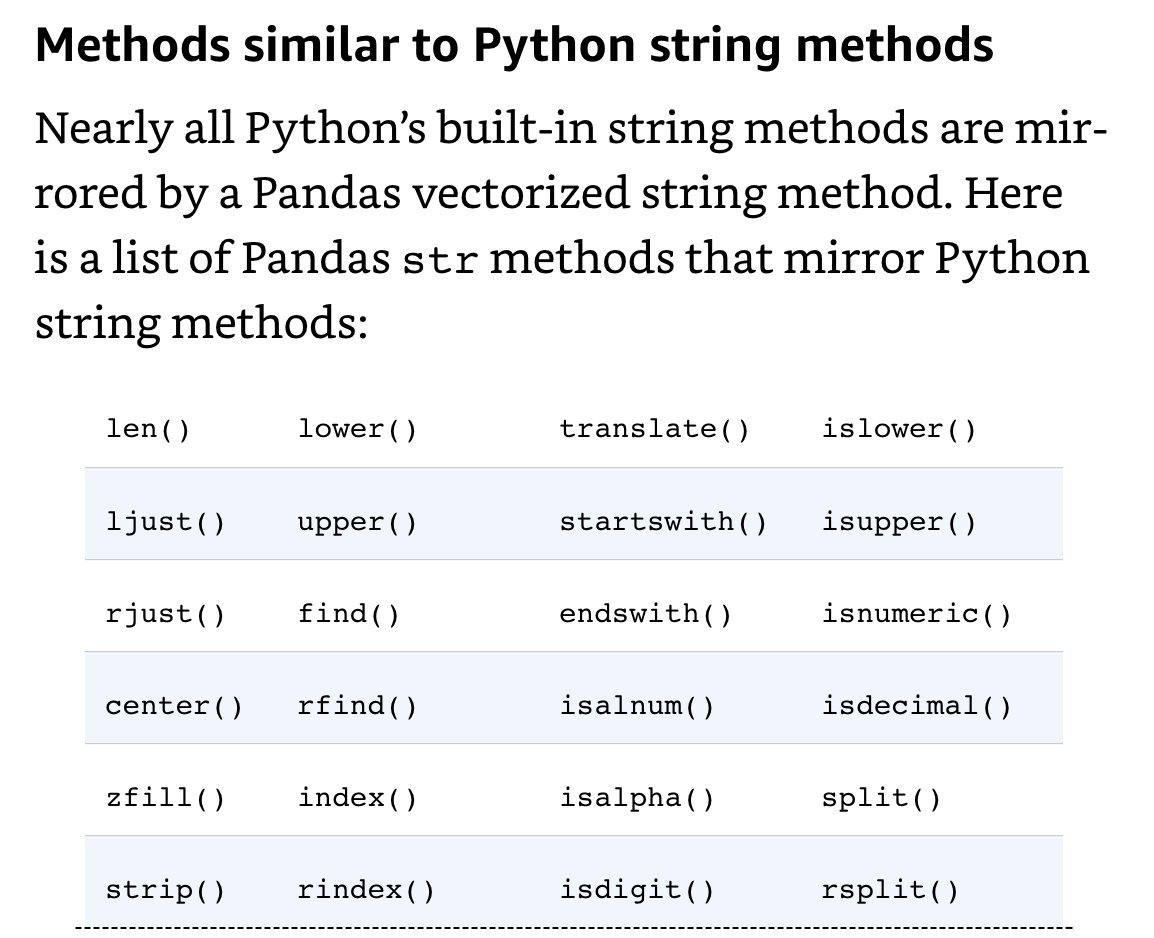

In [39]:
monte.str.lower()

0    graham chapman
1       john cleese
2     terry gilliam
3         eric idle
4       terry jones
5     michael palin
dtype: object

In [40]:
monte.str.len()

0    14
1    11
2    13
3     9
4    11
5    13
dtype: int64

In [41]:
monte.str.startswith('T')

0    False
1    False
2     True
3    False
4     True
5    False
dtype: bool

In [42]:
monte.str.split()

0    [Graham, Chapman]
1       [John, Cleese]
2     [Terry, Gilliam]
3         [Eric, Idle]
4       [Terry, Jones]
5     [Michael, Palin]
dtype: object

### Methods using regular expression

In [43]:
# extract the first name from each by asking for a continous group of characters at the beginning of each element
monte.str.extract('([A-Za-z]+)')

,0
0,Graham
1,John
2,Terry
3,Eric
4,Terry
5,Michael


In [44]:
# find all names that start and end with a consonant
# start-of-string char (^)
# end-of-string ($)
monte.str.findall(r'^[^AEIOU].*[^aeious]$')

0    [Graham Chapman]
1                  []
2     [Terry Gilliam]
3                  []
4                  []
5     [Michael Palin]
dtype: object

### Vectorized item access and slicing

In [45]:
monte.str.split().str.get(-1)

0    Chapman
1     Cleese
2    Gilliam
3       Idle
4      Jones
5      Palin
dtype: object

In [50]:
monte.str.split().str.get(0)

0     Graham
1       John
2      Terry
3       Eric
4      Terry
5    Michael
dtype: object

### Indicator variables

In [51]:
full_monte = pd.DataFrame({'name':monte, 'info': ['B|C|D', 'B|D', 'A|C', 'B|D', 'B|C', 'B|C|D']})
full_monte

,name,info
0,Graham Chapman,B|C|D
1,John Cleese,B|D
2,Terry Gilliam,A|C
3,Eric Idle,B|D
4,Terry Jones,B|C
5,Michael Palin,B|C|D


* `get_dummies()` lets you quickly split out these indicator variables 

In [52]:
full_monte['info'].str.get_dummies('|')

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1
